<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-OSSP1-Debugger-4/blob/Fid-score/CNN_AUTOENCODER_ver_FID_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 설정
from __future__ import absolute_import, division, print_function
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import gc
import glob

In [ ]:
#import for fid score 

!pip install import_ipynb 
import import_ipynb
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/') #fid 소스파일 경로
import fid  

#from scipy.misc import imread   미제...

def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
from tensorflow.keras.layers import Reshape

# 랜덤 시드 고정
SEED=2021
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
minsu = glob.glob('./drive/MyDrive/videoimage3/*.png')
test_minsu = []
for _ in range(0,len(minsu)):
  img = cv2.imread(minsu[_])
  img = cv2.resize(img,(64,64))
  test_minsu.append(img.astype("float32")/255.0)
  
test_minsu = np.array(test_minsu)

print(test_minsu.shape)

(1912, 64, 64, 3)


In [ ]:
# 오토인코더 모델 정의
def Autoencoder():
  #model = Sequnetial()

  X = tf.keras.layers.Input(shape=[64,64,3])

  #Encoder
  H = tf.keras.layers.Conv2D(32,(4,4),(2,2),activation='relu',padding='same')(X)
  H = tf.keras.layers.Conv2D(32*2,(4,4), (2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*4, (4,4),(2,2),activation='relu',padding='same')(H)
  H = tf.keras.layers.Conv2D(32*8, (4,4),(2,2),activation='relu',padding='same')(H)


  pool_tmp = H.shape.as_list()
  pool_tmp=pool_tmp[1:]
  

  #Fully-Connected
  H = tf.keras.layers.Flatten()(H)
  flatten_tmp=H.shape.as_list()
  flatten_tmp=flatten_tmp[1]
  H = tf.keras.layers.Dense(300,activation='relu')(H)
  H = tf.keras.layers.Dense(flatten_tmp,activation='relu')(H)
  H = Reshape(pool_tmp)(H)


  #Decoder
  H = tf.keras.layers.Conv2DTranspose(32*4,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32*2,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same',activation='relu')(H)
  H = tf.keras.layers.Conv2DTranspose(3,(2,2),strides=(2,2),padding='same',activation='sigmoid')(H)

  model = tf.keras.models.Model(X,H)
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['acc'])

  return model

ae_model = Autoencoder()
ae_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 32, 32, 32)        1568      
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 16, 16, 64)        32832     
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 4, 4, 256)         524544    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               122910

In [ ]:
# 오토인코더 모델 학습
history = ae_model.fit(test_minsu,
                       test_minsu,
                       batch_size=8,
                       epochs=20,
                       verbose=1,
                       )


Epoch 1/20
239/239 [==============================] - 20s 81ms/step - loss: 0.0355 - acc: 0.8048
Epoch 2/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0077 - acc: 0.8884
Epoch 3/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0046 - acc: 0.9080
Epoch 4/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0035 - acc: 0.9179
Epoch 5/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0028 - acc: 0.9239
Epoch 6/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0025 - acc: 0.9276
Epoch 7/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0023 - acc: 0.9311
Epoch 8/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0020 - acc: 0.9347
Epoch 9/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0019 - acc: 0.9370
Epoch 10/20
239/239 [==============================] - 19s 81ms/step - loss: 0.0019 - acc: 0.9377
Epoch 11/20
239/239 [========

In [ ]:
#테스트 데이터 Prediction
ae_images = ae_model.predict(test_minsu)
ae_images.shape

(1912, 64, 64, 3)

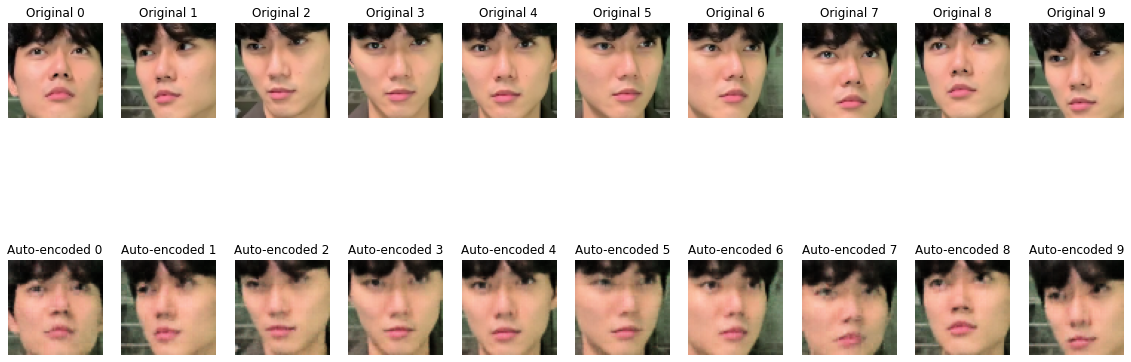

In [ ]:
#이미지 출력
num = 10 
plt.figure(figsize=(20,8))

for i in range(10):
    # 원본 이미지
    ax = plt.subplot(2, num, i+1)
    plt.imshow(cv2.cvtColor(test_minsu[i*50], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Original %s" % str(i))
    plt.axis('off')
    
    # 복원 이미지
    ax = plt.subplot(2, num, i+num+1)
    plt.imshow(cv2.cvtColor(ae_images[i*50], cv2.COLOR_BGR2RGB).reshape((64,64,3)))
    plt.title("Auto-encoded %s" % str(i))
    plt.axis('off')
  
plt.show()

In [ ]:
 # fid score 
    # generated images np
    #image_list = glob.glob(ae_images)
    #
    #real data set images np
    #Dimages_list = glob.glob(test_minsu)
    #Dimages = np.array([imread(str(fn)).astype(np.float32) for fn in files])


#with tf.Session() as sess:
#sess.run(tf.global_variables_initializer())
###mu_real, sigma_real = fid.calculate_activation_statistics(test_minsu, sess, batch_size=100) #test_minsu = Dimages 

#fid score deleted part
"""
stats_path = 'fid_stats.npz' # training set statistics 
f = np.load(stats_path)
mu_real, sigma_real = f['mu'][:], f['sigma'][:]
f.close()
"""
"""

fid.create_inception_graph(inception_path)  # load the graph into the current TF graph


image_path = ae_images

def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


#결과 images
inception_path = fid.check_or_download_inception(None) # download inception network
#image_list = glob.glob(os.path.join(ae_images, '*.jpg'))
#images = np.array([imread(str(fn)).astype(np.float32) for fn in image_list])

fid.create_inception_graph(inception_path)

sess = tf.compat.v1.Session()
sess.run(variables_initializer(global_variables())) #tf.global_variables_initializer()
mu_auto, sigma_auto = fid.calculate_activation_statistics(ae_images, sess, batch_size=100) #ae_images = images d
sess.close()
 
#fid score 결과
fid_value = fid.calculate_frechet_distance(mu_auto, sigma_auto, mu_real, sigma_real)
print("FID: %s" % fid_value)
"""



KeyError: ignored

In [ ]:
# using fid implementation in this sitehttps://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
#Compute Fid Score

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))


# define two collections of images
images1 = test_minsu
#images1 = images1.reshape((10,32,32,3))
images1 = images1.reshape((1912, 64, 64, 3))
images2 = ae_images
#images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)


# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images

images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)


Prepared (1912, 64, 64, 3) (1912, 64, 64, 3)
Scaled (1912, 299, 299, 3) (1912, 299, 299, 3)
FID (different): 0.301
